# Setup

Clone repo, install dependencies, `%cd` into `./yolov5` folder and check GPU.

In [1]:
!git clone https://github.com/CiperLabs/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets
import shutil
import os
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0 CPU


In [1]:
import pandas as pd
from shutil import copyfile
annotations = pd.read_csv("../data/annotations.csv")
image_folder = '../vims_data/images/all'
train_image_folder = '../vims_data/images/train1'

FileNotFoundError: [Errno 2] No such file or directory: '../data/annotations.csv'

In [4]:
class_id_map = {56 : 0, 296 : 1,164:2,24:3,8:4,104:5,172:6,168:7,20:8,160:9,292:10,288:11,1:12}
image_widths_map = {14: 2560, 15: 1280,16: 480,17 : 427,18:213}
image_heights_map = {14: 3840, 15: 1920,16: 720,17 : 640,18 : 320 }

class_id_df = pd.DataFrame(class_id_map.items(),columns=['product_id','class_id'])
annotations = annotations.merge(class_id_df,on='product_id')
annotations = annotations.loc[(annotations.camera_id == 14 ) | (annotations.camera_id == 15) | (annotations.camera_id == 16)| (annotations.camera_id == 17)| (annotations.camera_id == 18) ]

image_widths_df = pd.DataFrame(image_widths_map.items(),columns=['camera_id','image_width'])
image_heights_df = pd.DataFrame(image_heights_map.items(),columns=['camera_id','image_height'])
annotations = annotations.merge(image_heights_df, on ='camera_id')
annotations = annotations.merge(image_widths_df, on='camera_id')
# On Google Cloud
try:
  os.makedirs(train_image_folder)
except OSError:
  import shutil
  shutil.rmtree(train_image_folder)
  os.makedirs(train_image_folder)


NameError: name 'annotations' is not defined

In [ ]:
#Downloading the images
import urllib.request
for image_name in annotations['name'].unique():
    url="http://tempo-llc.com/storage/uploads/warehouse_images/"+image_name
    print(url)
    dest = train_image_folder+ "/" + image_name
    urllib.request.urlretrieve(url, dest)

In [2]:
def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [3]:
label_destination = "../vims_data/labels/train1/"
try:
  os.makedirs(label_destination)
except OSError:
  shutil.rmtree(label_destination)
  os.makedirs(label_destination)
for name,annotations_group in annotations.groupby('ware_house_image_id'):
    for index,annotation in annotations_group.iterrows():
        out_file_path = label_destination + annotation['name'].replace('.jpg','.txt')
        out_file = open(out_file_path, 'a')
        print(out_file_path)
        bb = convert([2560,3840],[annotation['bndbox_xmin'],annotation['bndbox_xmax'],annotation['bndbox_ymin'],annotation['bndbox_ymax']])
        print(bb)
        cls_id = annotation['class_id']
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
        out_file.close()

NameError: name 'annotations' is not defined

Inference can be run on a variety of sources: images, videos, directories, webcams, rtsp and http streams as shown in the example below.

# 3. Train

Train a YOLOv5s model on vims_data by specifying model config file `--cfg models/yolo5s.yaml`, and dataset config file `--data data/vims.yaml`. Start training from pretrained `--weights yolov5s.pt`, or from randomly initialized `--weights ''`.
**All training results are saved to `runs/exp0`** for the first experiment, then `runs/exp1`, `runs/exp2` etc. for subsequent experiments.


In [2]:
# Start tensorboard (optional)
%load_ext tensorboard
%tensorboard --logdir runs

In [2]:
# Train YOLOv5s on coco128 for 3 epochs : --rect for rectangular training
!python3 train.py --batch 16 --img-size 640 --epochs 300 --data vims.yaml --cfg yolov5s-vims.yaml --nosave --cache --hyp data/hyp.scratch.yaml --weights ''

Using CPU

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/yolov5s-vims.yaml', data='./data/vims.yaml', device='', epochs=3, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[2560, 3840], local_rank=-1, logdir='runs/', multi_scale=False, name='', noautoanchor=False, nosave=True, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0

# 4. Visualize

View `runs/exp0/train*.jpg` images to see training images, labels and augmentation effects. A **Mosaic Dataloader** is used for training (shown below), a new concept developed by Ultralytics and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

View `test_batch0_gt.jpg` to see test batch 0 *ground truth* labels.

In [5]:
Image(filename='runs/exp0/test_batch0_gt.jpg', width=1000)

NameError: name 'Image' is not defined

View `test_batch0_pred.jpg` to see test batch 0 *predictions*.

In [5]:
Image(filename='runs/exp0/test_batch0_pred.jpg', width=1000)

FileNotFoundError: [Errno 2] No such file or directory: 'runs/exp0/train*.jpg'

In [ ]:
Image(filename='runs/exp0/results.png', width=1000)

Training losses and performance metrics are saved to Tensorboard and also to a `runs/exp0/results.txt` logfile. `results.txt` is plotted as `results.png` after training completes. Partially completed `results.txt` files can be plotted with `from utils.general import plot_results; plot_results()`. Here we show YOLOv5s trained on coco128 to 300 epochs, starting from scratch (blue), and from pretrained `yolov5s.pt` (orange).

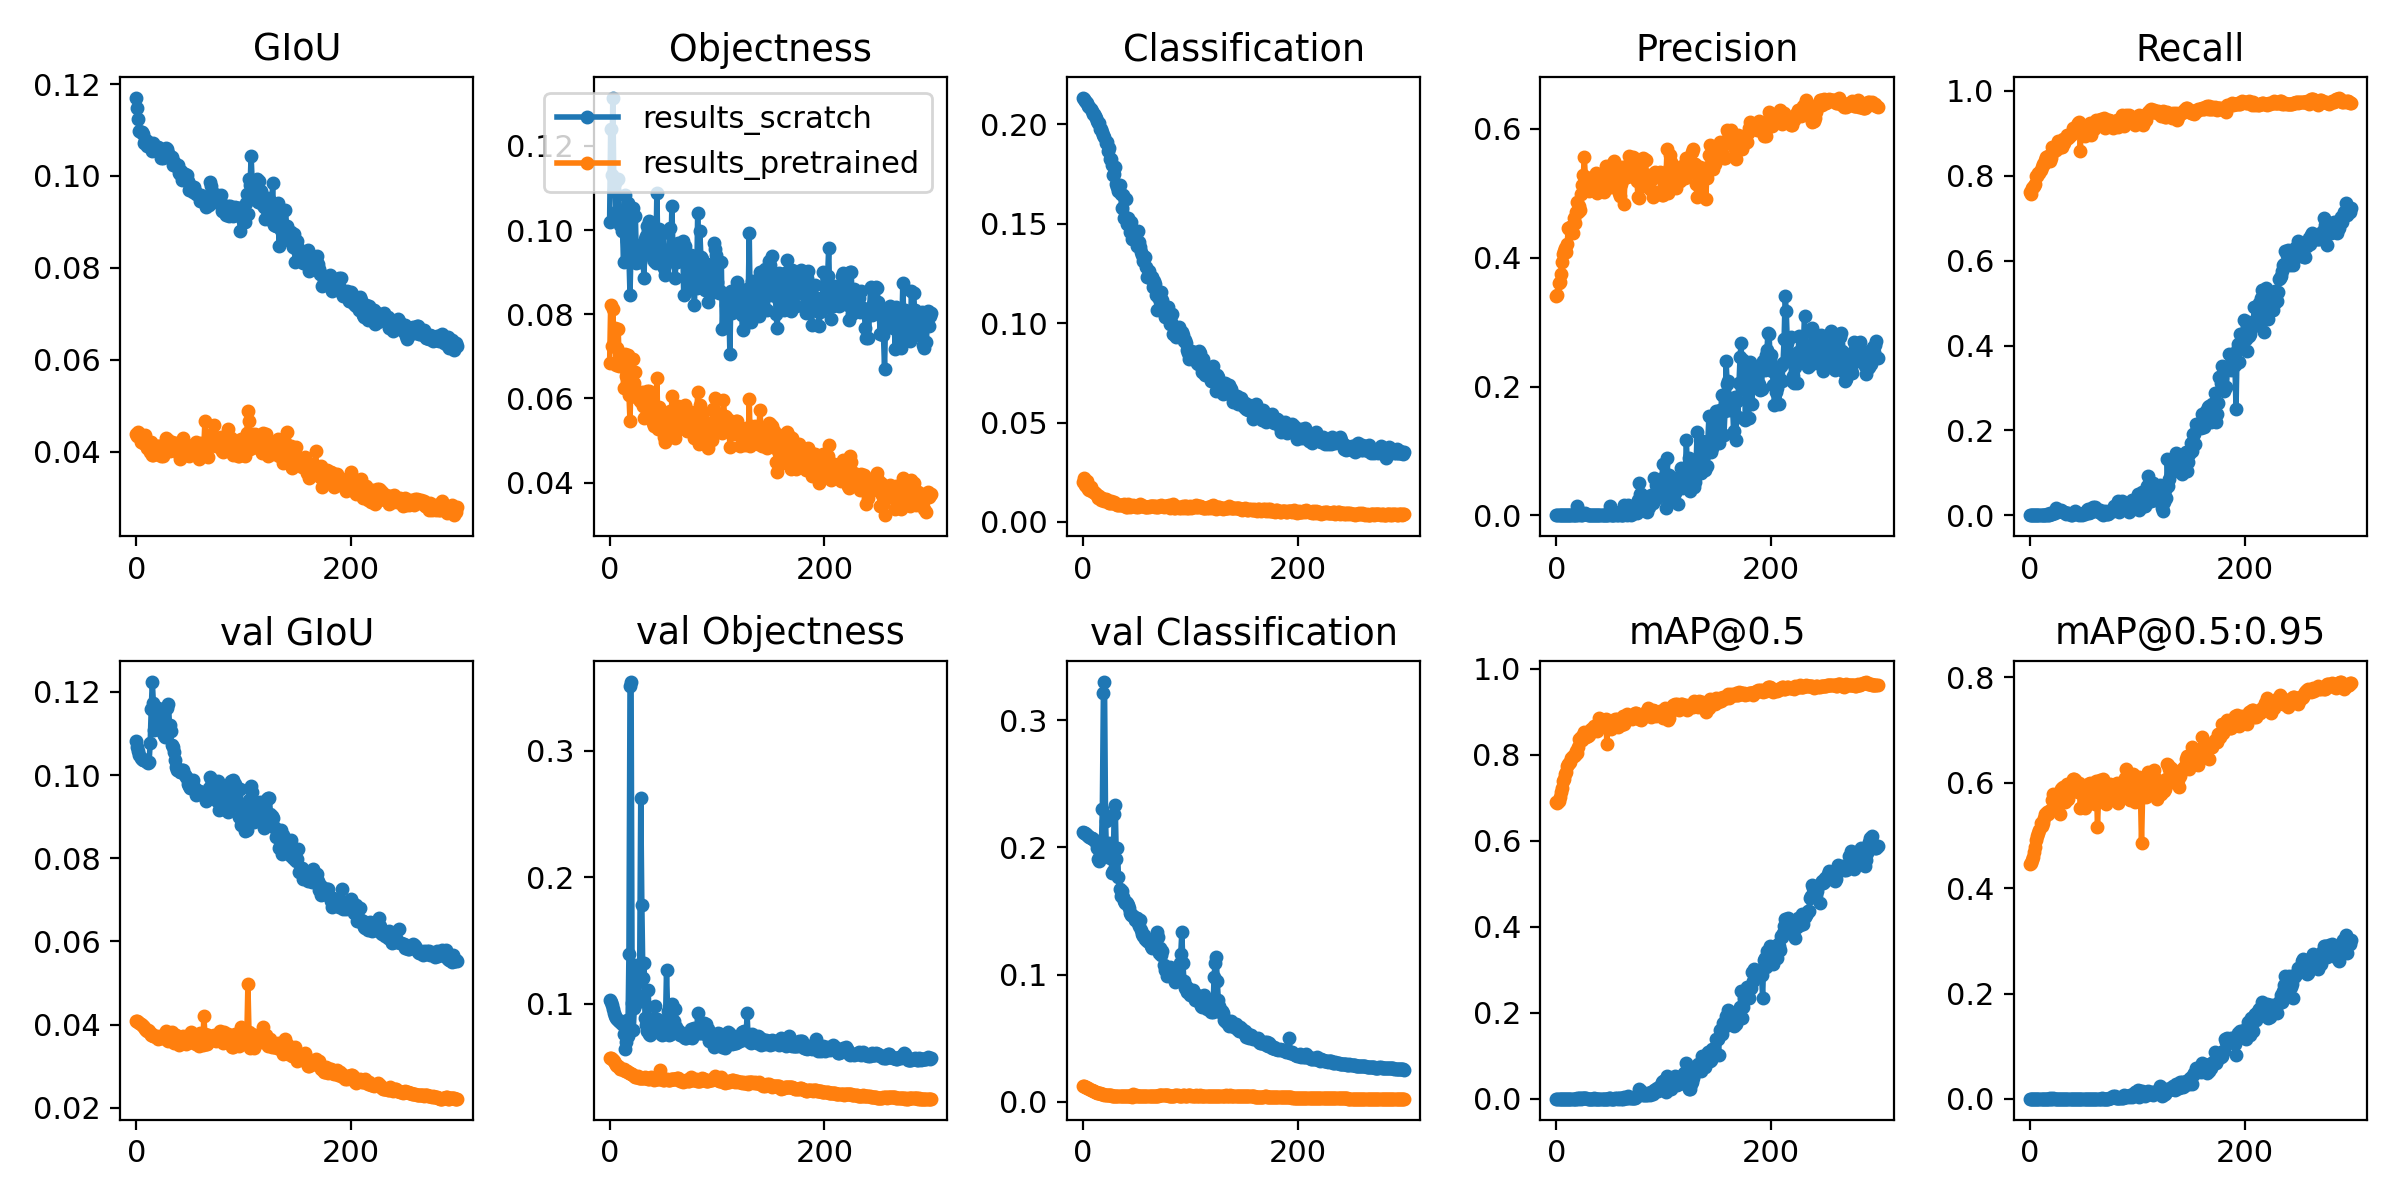

In [ ]:
from utils.general import plot_results; plot_results()  # plot results.txt files as results.png

# 1. Inference

Run inference with a pretrained checkpoint on contents of `/inference/images` folder. Models are auto-downloaded 

In [2]:
!python3 detect.py --weights yolov5s.pt --img 416 --conf 0.4 --source ../vims_data/train1/ --output ../vims_data/output

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.5, output='../vims_data/output', save_txt=False, source='../vims_data/train_1/', update=False, view_img=False, weights=['yolov5s.pt'])
Using CPU

Fusing layers... 
Model Summary: 140 layers, 7.45958e+06 parameters, 6.61683e+06 gradients
Traceback (most recent call last):
  File "detect.py", line 173, in <module>
    detect()
  File "detect.py", line 55, in detect
    dataset = LoadImages(source, img_size=imgsz)
  File "/home/education/Repositories/yolov5/utils/datasets.py", line 120, in __init__
    raise Exception('ERROR: %s does not exist' % p)
Exception: ERROR: /home/education/Repositories/vims_data/train_1 does not exist


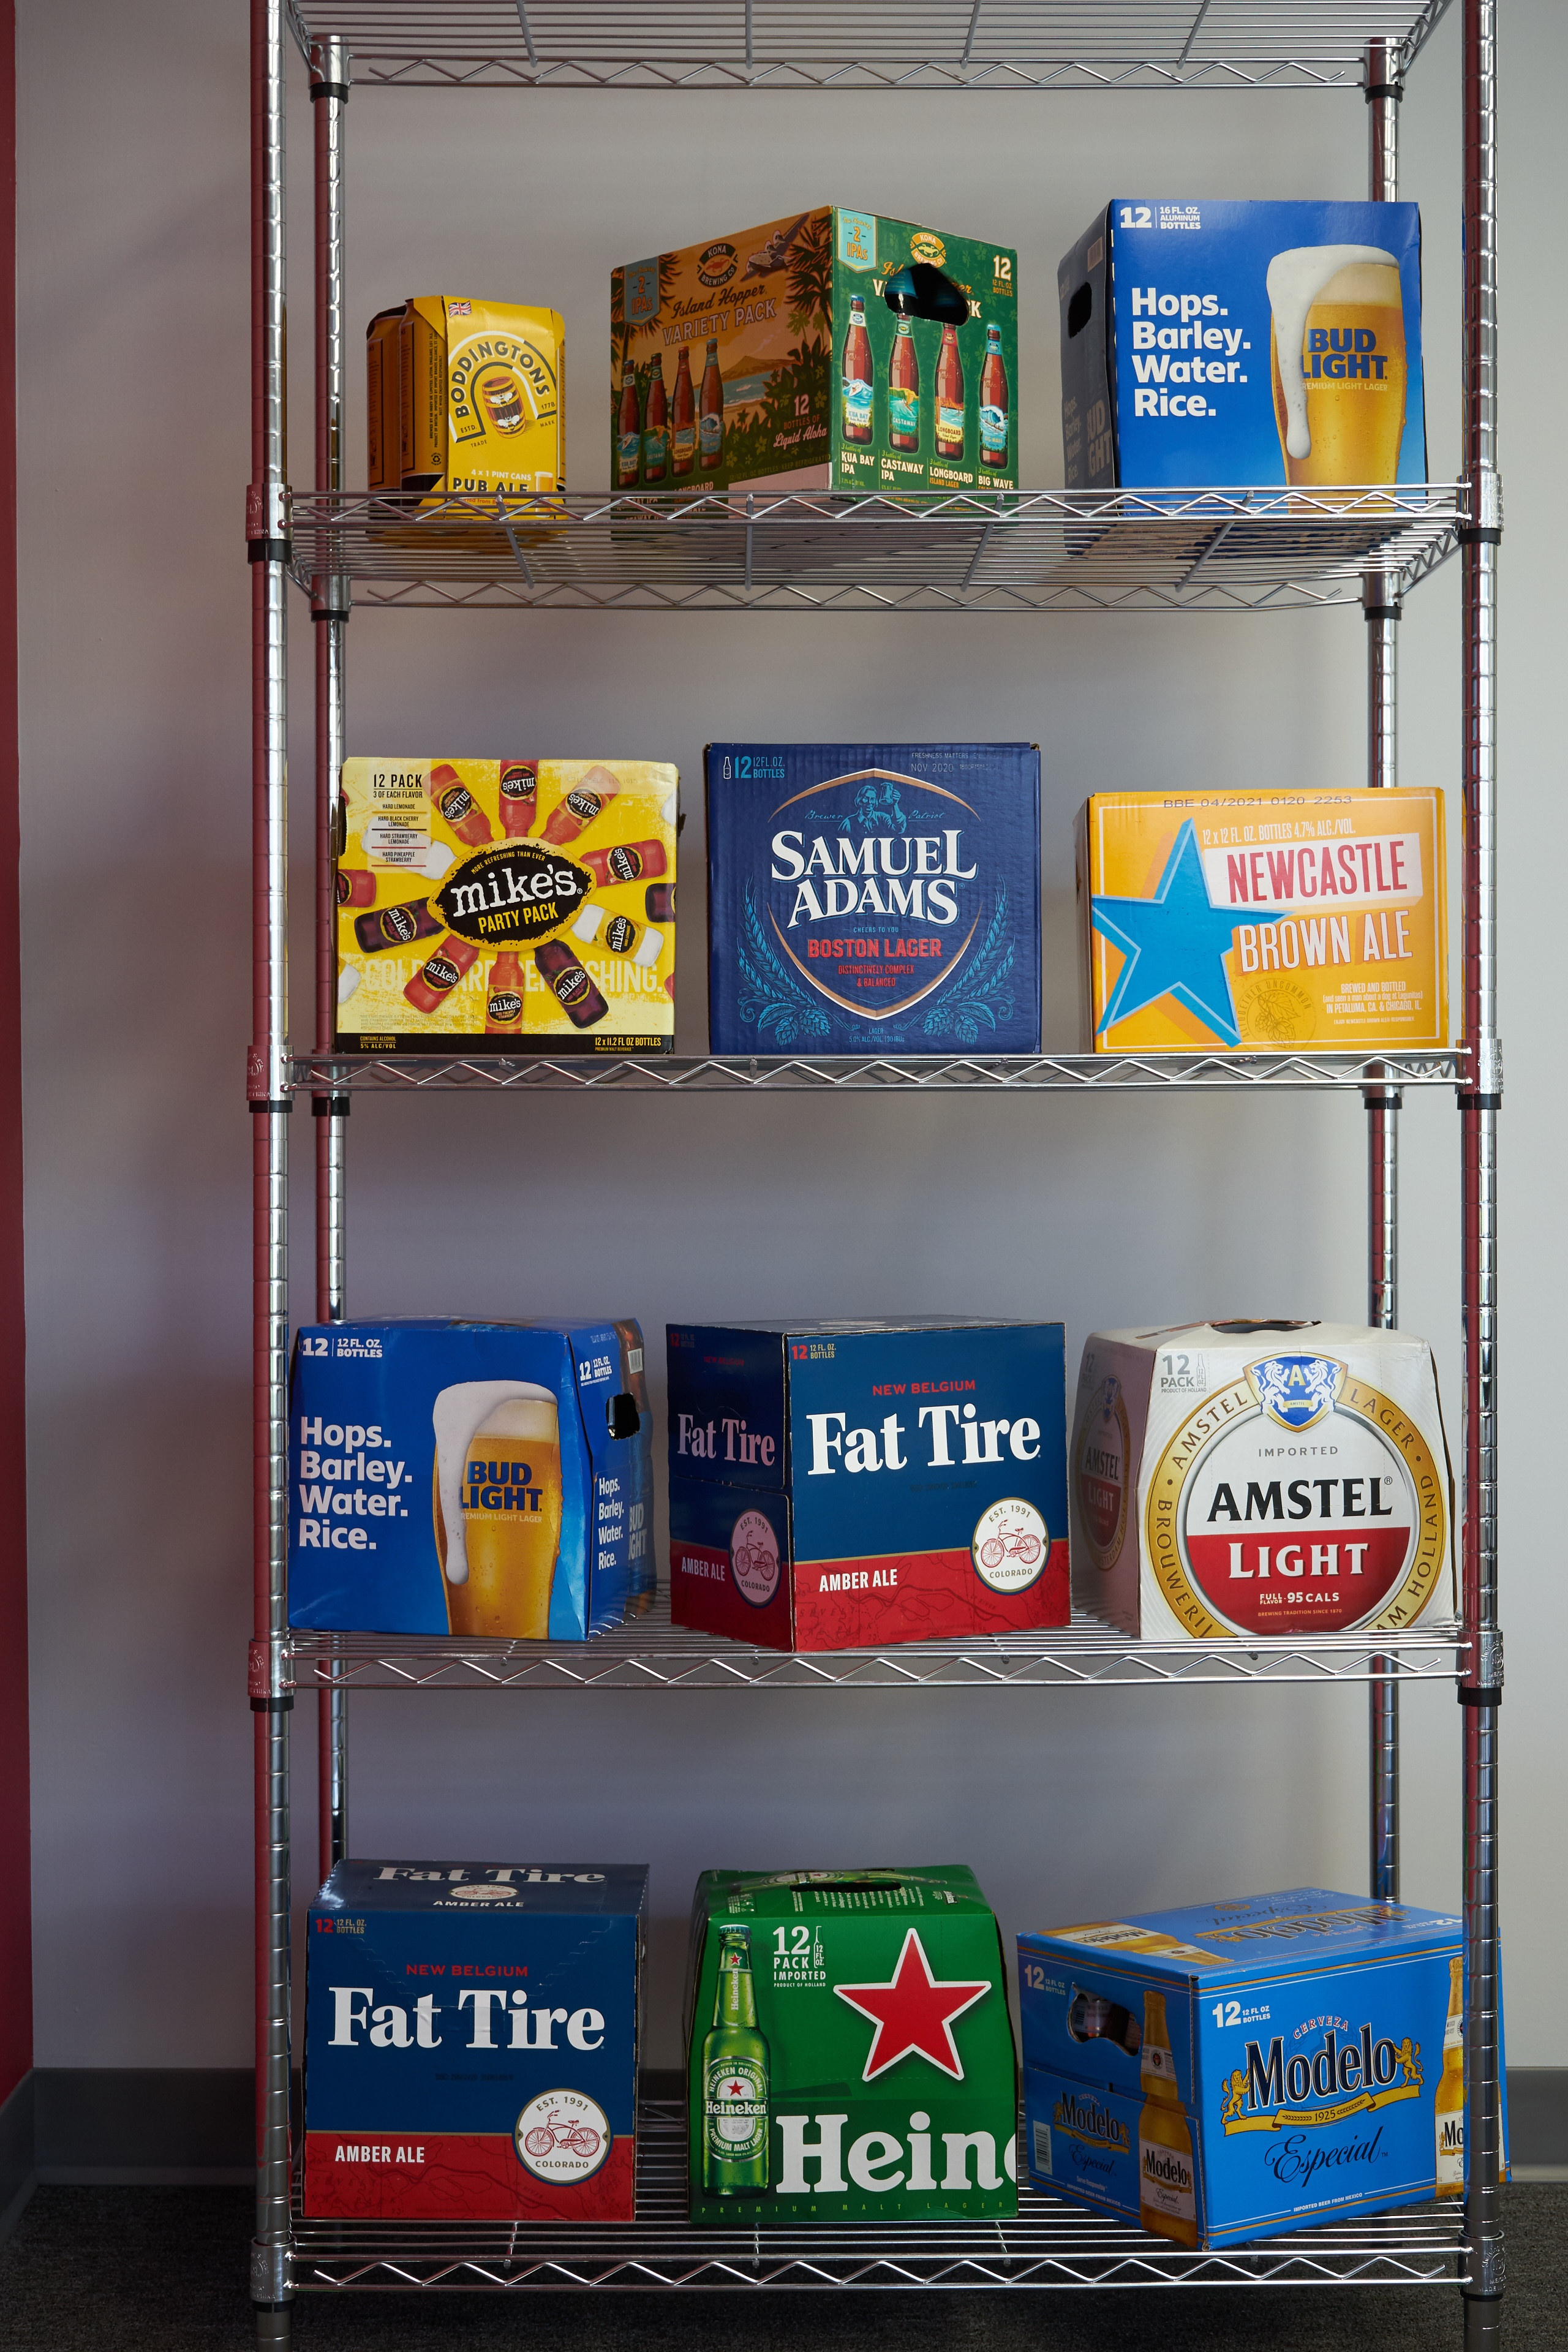

In [8]:
Image(filename='../vims_data/output/1597738371610200806-tempo-test-a-0002-3840jpg_1597738431.jpg', width=600)

In [ ]:
# Example syntax (do not run cell)
!python detect.py --source file.jpg  # image 
                           file.mp4  # video
                           dir/  # directory
                           0  # webcam
                           'rtsp://170.93.143.139/rtplive/470011e600ef003a004ee33696235daa' # rtsp
                           'http://112.50.243.8/PLTV/88888888/224/3221225900/1.m3u8'  # http

# Appendix

Optional extras below. Unit tests validate repo functionality and should be run on any PRs submitted.


In [ ]:
# Re-clone repo
%cd ..
!rm -rf yolov5 && git clone https://github.com/ultralytics/yolov5
%cd yolov5

In [ ]:
# Test GCP ckpt
%%shell
for x in best*
do
  gsutil cp gs://*/*/*/$x.pt .
  python test.py --weights $x.pt --data coco.yaml --img 672
done

In [ ]:
# YOLOv5 unit tests
%%shell
cd .. && rm -rf yolov5 && git clone https://github.com/ultralytics/yolov5 && cd yolov5
export PYTHONPATH="$PWD" # to run *.py. files in subdirectories
pip install -qr requirements.txt onnx
python3 -c "from utils.google_utils import *; gdrive_download('1n_oKgR81BJtqk75b00eAjdv03qVCQn2f', 'coco128.zip')" && mv ./coco128 ../
for x in yolov5s #yolov5m yolov5l yolov5x # models
do
  python train.py --weights $x.pt --cfg $x.yaml --epochs 4 --img 320 --device 0  # train
  for di in 0 cpu # inference devices
  do
    python detect.py --weights $x.pt --device $di  # detect official
    python detect.py --weights runs/exp0/weights/last.pt --device $di  # detect custom
    python test.py --weights $x.pt --device $di # test official
    python test.py --weights runs/exp0/weights/last.pt --device $di # test custom
  done
  python models/yolo.py --cfg $x.yaml # inspect
  python models/export.py --weights $x.pt --img 640 --batch 1 # export
done